In [42]:
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import json
from pprint import pprint

import pickle

%matplotlib inline

## 1. Load data

In [43]:
PATH_TO_XDATA = 'data/slabs/XDATA_SL.TXT'
PATH_TO_XMATDOC_DATA = 'data/slabs/XMATDOC.TXT'
PATH_TO_YDATA = 'data/slabs/YDATA_SL.TXT'

In [44]:
dateparser = lambda x: pd.datetime.strptime(x, '%Y%m%d')
sumparser = lambda x: float(x[:-1])

xdata = pd.read_csv(PATH_TO_XDATA, header=None, names=['DAT', 'SUM', 'ACCNT', 'MATNR','V5'],
                    parse_dates=['DAT'], dtype = {'SUM': float, 'ACCNT': str},
                    date_parser=dateparser, thousands='.', decimal=',')

xdata.drop(['MATNR','V5'], axis=1, inplace=True)
xdata.head()

,DAT,SUM,ACCNT
0,2017-02-28,5.257557e+06,3802025999
1,2017-02-28,6.306524e+07,3802025999
2,2017-02-28,3.793658e+09,3802025999
3,2017-02-28,4.231031e+06,3802025999
4,2017-02-28,4.336471e+06,3802025999


In [45]:
dateparser = lambda x: pd.datetime.strptime(x, '%Y%m%d')
sumparser = lambda x: float(x[:-1])

ydata = pd.read_csv(PATH_TO_YDATA, header=None, names=['DAT', 'SUM', 'ACCNT', 'V4','V5'],
                    parse_dates=['DAT'], dtype = {'ACCNT': str}, converters = {'SUM': sumparser},
                    date_parser=dateparser, thousands='.', decimal=',')

ydata.drop(['ACCNT','V4', 'V5'], axis=1, inplace=True)
ydata.head()

,DAT,SUM
0,2017-01-09,39689884.90
1,2017-03-22,58451082.51
2,2015-05-21,2165692.54
3,2015-07-20,11272605.63
4,2015-07-23,3827463.40


In [46]:
dateparser = lambda x: pd.datetime.strptime(x, '%Y%m%d')
sumparser = lambda x: float(x[:-1])

xmatdoc_data = pd.read_csv(PATH_TO_XMATDOC_DATA, header=None, names=['DAT', 'SUM'],
                    parse_dates=['DAT'], dtype = {'ACCNT': str, 'SUM': float},
                    date_parser=dateparser, thousands='.', decimal=',')
xmatdoc_data.head()

,DAT,SUM
0,2014-04-23,53561200.0
1,2014-04-23,40250800.0
2,2014-04-23,49926437.0
3,2014-04-23,49926437.0
4,2014-04-23,55610400.0


## 2. Data preparation

### 2.1 YDATA

In [6]:
y_byday = ydata.groupby(by=['DAT']).sum().reset_index()
y_byday.head()

,DAT,SUM
0,2014-01-09,2.473907e+08
1,2014-01-13,1.031410e+08
2,2014-01-22,2.108867e+08
3,2014-01-24,1.040741e+08
4,2014-01-27,1.033021e+08


Split date into year_month/day:

In [7]:
y_byday['DAY'] = [date.day for date in y_byday.DAT]
y_byday['MONTH'] = [date.month for date in y_byday.DAT]
y_byday['YEAR'] = [date.year for date in y_byday.DAT]
y_byday.drop(['DAT'],axis=1, inplace=True)
y_byday = y_byday[['DAY','MONTH','YEAR', 'SUM']] 
y_byday.head()

,DAY,MONTH,YEAR,SUM
0,9,1,2014,2.473907e+08
1,13,1,2014,1.031410e+08
2,22,1,2014,2.108867e+08
3,24,1,2014,1.040741e+08
4,27,1,2014,1.033021e+08


In [8]:
y_bymonth = y_byday.groupby(by=['YEAR','MONTH']).sum().reset_index()
y_bymonth.drop(['DAY'], axis=1, inplace=True)

# <font color="red"> Sum for grouped by YEAR:</font>

In [9]:
y_byyear = y_byday.groupby(by=['YEAR']).sum().reset_index()
y_byyear.drop(['DAY','MONTH'], axis=1, inplace=True)
y_byyear

,YEAR,SUM
0,2014,9.256203e+09
1,2015,1.128557e+10
2,2016,2.348478e+10
3,2017,7.758829e+09


#### Drop 3-th month of 2017 year, cause in XDATA we have only data from 2014-01 -> 2017-02

In [10]:
y_bymonth.drop(y_bymonth[(y_bymonth.YEAR == 2017) & (y_bymonth.MONTH == 3)].index, axis=0, inplace=True)

In [11]:
y_bymonth.shape

(26, 3)

### 2.2 XDATA

In [12]:
xdata.head()

,DAT,SUM,ACCNT
0,2017-02-28,5.257557e+06,3802025999
1,2017-02-28,6.306524e+07,3802025999
2,2017-02-28,3.793658e+09,3802025999
3,2017-02-28,4.231031e+06,3802025999
4,2017-02-28,4.336471e+06,3802025999


In [13]:
x_byday = xdata.groupby(by=['DAT', 'ACCNT']).sum().reset_index()
xmatdoc_byday = xmatdoc_data.groupby(by=['DAT']).sum().reset_index()
x_byday.head()

,DAT,ACCNT,SUM
0,2014-01-31,3802025015,5.363860e+06
1,2014-01-31,3802025018,1.303150e+09
2,2014-01-31,3802025063,4.924695e+08
3,2014-01-31,3802025504,4.288226e+09
4,2014-01-31,3802025518,2.088984e+07


In [14]:
x_accnts = np.unique(x_byday.ACCNT)
print(x_accnts)

['3802025015' '3802025017' '3802025018' '3802025063' '3802025066'
 '3802025504' '3802025518' '3802025519' '3802025997' '3802025998'
 '3802025999']


In [15]:
print('Unique dates:', np.unique(x_byday.DAT))
print('\nNumber of dates:', len(np.unique(x_byday.DAT)))

Unique dates: ['2014-01-31T00:00:00.000000000' '2014-02-28T00:00:00.000000000'
 '2014-03-31T00:00:00.000000000' '2014-04-30T00:00:00.000000000'
 '2014-05-31T00:00:00.000000000' '2014-06-30T00:00:00.000000000'
 '2014-07-31T00:00:00.000000000' '2014-08-31T00:00:00.000000000'
 '2014-09-30T00:00:00.000000000' '2014-10-31T00:00:00.000000000'
 '2014-11-30T00:00:00.000000000' '2014-12-31T00:00:00.000000000'
 '2015-01-31T00:00:00.000000000' '2015-02-28T00:00:00.000000000'
 '2015-03-31T00:00:00.000000000' '2015-04-30T00:00:00.000000000'
 '2015-05-31T00:00:00.000000000' '2015-06-30T00:00:00.000000000'
 '2015-07-31T00:00:00.000000000' '2015-08-31T00:00:00.000000000'
 '2015-09-30T00:00:00.000000000' '2015-10-31T00:00:00.000000000'
 '2015-11-30T00:00:00.000000000' '2015-12-31T00:00:00.000000000'
 '2016-01-31T00:00:00.000000000' '2016-02-29T00:00:00.000000000'
 '2016-03-31T00:00:00.000000000' '2016-04-30T00:00:00.000000000'
 '2016-05-31T00:00:00.000000000' '2016-06-30T00:00:00.000000000'
 '2016-07-3

In [16]:
print('Data size:\t', x_byday.shape)

Data size:	 (279, 3)


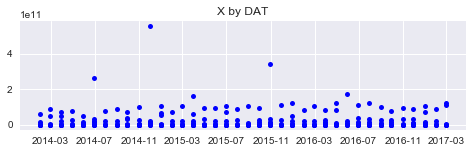

In [17]:
x = x_byday.DAT.copy()
y = x_byday.SUM.copy()
plt.figure(figsize=(8,2))
plt.plot(x,y, 'b.', ms=10)
plt.title('X by DAT')
plt.grid
plt.show()

Split date into year_month/day:

In [18]:
x_bymonth = x_byday.copy()
x_bymonth['MONTH'] = [date.month for date in x_bymonth.DAT]
x_bymonth['YEAR'] = [date.year for date in x_bymonth.DAT]
x_bymonth.drop(['DAT'],axis=1, inplace=True)
x_bymonth = x_bymonth[['MONTH','YEAR', 'SUM','ACCNT']] 


xmatdoc_bymonth = xmatdoc_byday.copy()
xmatdoc_bymonth['MONTH'] = [date.month for date in xmatdoc_bymonth.DAT]
xmatdoc_bymonth['YEAR'] = [date.year for date in xmatdoc_bymonth.DAT]
xmatdoc_bymonth.drop(['DAT'],axis=1, inplace=True)
xmatdoc_bymonth = xmatdoc_bymonth[['MONTH','YEAR', 'SUM']] 
xmatdoc_bymonth = xmatdoc_bymonth.groupby(by=['YEAR','MONTH']).sum().reset_index()
xmatdoc_bymonth.drop(xmatdoc_bymonth[(xmatdoc_bymonth.YEAR == 2017) & (xmatdoc_bymonth.MONTH == 3)].index, axis=0, inplace=True)
xmatdoc_bymonth.reset_index(inplace=True)
xmatdoc_bymonth.drop(['MONTH', 'YEAR', 'index'],axis=1, inplace=True)

In [19]:
xsum = x_bymonth.drop(['ACCNT'], axis=1, inplace=False)
xsum = xsum.groupby(by=['YEAR','MONTH']).sum().reset_index()

#### Resize our XDATA:

In [20]:
last_year = np.unique(y_bymonth.YEAR)[-1]
last_month = np.unique(y_bymonth.MONTH[y_bymonth.YEAR == last_year])[-1]

first_year = np.unique(y_bymonth.YEAR)[0]
first_month = np.unique(y_bymonth.MONTH[y_bymonth.YEAR == last_year])[0]

N_MONTHS = (last_year-first_year) * 12 + last_month - first_month + 1

N_ACCNTS = len(x_accnts)
print(x_accnts)

['3802025015' '3802025017' '3802025018' '3802025063' '3802025066'
 '3802025504' '3802025518' '3802025519' '3802025997' '3802025998'
 '3802025999']


In [21]:
X = pd.DataFrame(data=np.zeros((N_MONTHS, N_ACCNTS)), columns=np.arange(N_ACCNTS), index=np.arange(N_MONTHS))
for accnt,i in zip(x_accnts, np.arange(N_ACCNTS)):
    for month, year in zip(x_bymonth[x_bymonth.ACCNT == accnt].MONTH, x_bymonth[x_bymonth.ACCNT == accnt].YEAR):
        X[i].iloc[(month-1) + 12*(year-2014)] = x_bymonth[(x_bymonth.ACCNT == accnt) & (x_bymonth.MONTH == month)& (x_bymonth.YEAR == year)].SUM.values[0]

In [22]:
X

,0,1,2,3,4,5,6,7,8,9,10
0,5363860.0,0.0,1.303150e+09,4.924695e+08,0.0,4.288226e+09,2.088984e+07,5.975710e+10,0.0,0.000000e+00,1.809790e+10
1,0.0,7300072.0,1.129713e+09,4.409600e+08,0.0,4.430002e+09,0.000000e+00,8.653444e+10,0.0,0.000000e+00,4.961550e+10
2,0.0,13867563.0,1.261419e+09,4.208694e+08,0.0,5.226320e+09,0.000000e+00,6.968537e+10,133181704.0,2.317853e+10,4.906368e+10
3,0.0,1324407.0,1.322120e+09,7.216733e+08,0.0,4.157749e+09,0.000000e+00,7.640161e+10,0.0,6.320590e+05,2.512859e+10
4,388691.0,2241126.0,8.809684e+08,4.594114e+08,21999419.0,3.364891e+09,5.427332e+09,4.940677e+10,0.0,0.000000e+00,1.329558e+10
5,0.0,17200000.0,5.370869e+09,4.364447e+08,0.0,1.805936e+10,0.000000e+00,2.652726e+11,114869789.0,1.971609e+10,3.211719e+10
6,0.0,0.0,1.444667e+09,6.115106e+08,0.0,2.643455e+09,0.000000e+00,7.650714e+10,0.0,0.000000e+00,2.121685e+10
7,0.0,13454035.0,1.204596e+09,4.793448e+08,0.0,2.850423e+09,0.000000e+00,8.945263e+10,0.0,0.000000e+00,2.174150e+10
8,0.0,9118301.0,1.374734e+09,5.919861e+08,29273853.0,5.516522e+09,0.000000e+00,7.335859e+10,234891520.0,3.941544e+10,3.136882e+10
9,305453.0,2973390.0,1.873354e+09,8.621252e+08,0.0,5.249106e+09,6.864835e+09,9.778947e+10,0.0,3.166302e+07,2.706838e+10


In [23]:
X_matdoc = pd.concat((X,xmatdoc_bymonth), axis=1)

In [24]:
X_matdoc = X_matdoc.copy().values

In [25]:
y = np.zeros((N_MONTHS,))
for month, year in zip(y_bymonth.MONTH, y_bymonth.YEAR):
    y[(month-1) + 12*(year-2014)] = y_bymonth[(y_bymonth.MONTH == month)  & (y_bymonth.YEAR == year)].SUM.values[0]

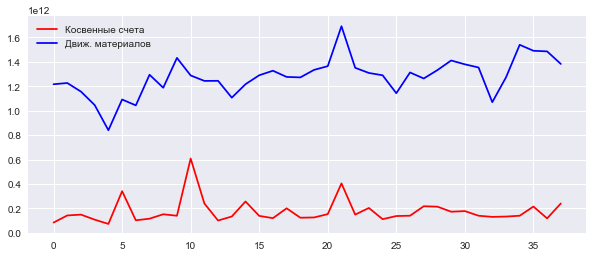

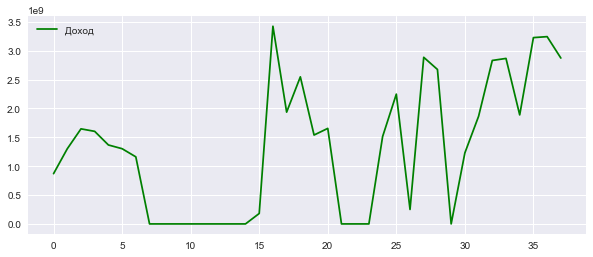

In [26]:
#plt.subplot(211)
plt.figure(figsize=(10,4))
plt.plot(xsum.SUM, 'r', label='Косвенные счета')
plt.plot(xmatdoc_bymonth.SUM, 'b', label='Движ. материалов')
plt.legend()
plt.show()
#plt.subplot(212)
plt.figure(figsize=(10,4))
plt.plot(y, 'g', label='Доход')
plt.legend()
plt.show()

### 2.3 Prepare date for training

In [27]:
def resize_x_data(X, y, history=3):
    #history is 3 months by default
    N_MONTHS, N_ACCNTS,  = X.shape
    new_size = (N_MONTHS - history, history * N_ACCNTS)
    X_new = np.zeros(new_size)
    
    for i in range(new_size[0]):
        for j in reversed(range(1, history+1)):
            if j==history:
                a = X[i,:]
            else:
                a = np.concatenate((a,X[i + history - j]))
        X_new[i,:] = a

    return X_new

def resize_y_data(y, history=3):
    return y[history:]

In [28]:
X_new = resize_x_data(X_matdoc, y)

In [29]:
X_new.shape

(35, 36)

In [30]:
y_new = resize_y_data(y)

In [31]:
y_new.shape

(35,)

## 3. Training

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

In [33]:
def preprocess_data(X,y, history, test_size=0.2):
    #resize our data
    assert history > 0
    X_new = resize_x_data(X,y, history)
    y_new = resize_y_data(y, history)
    #scale them
    ss = StandardScaler()
    X_ss = ss.fit_transform(X_new)
    Y_MEAN = y_new.mean()
    Y_STD = y_new.std()
    y_ss = (y_new - y_new.mean())/y_new.std()
    #split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X_ss, y_ss, test_size=test_size, shuffle=False)
    
    return X_train, X_test, y_train, y_test, ss, Y_MEAN, Y_STD

#### FIX test size:

In [34]:
test_size = 0.2

In [35]:
X_train, X_test, y_train, y_test, ss, Y_MEAN, Y_STD = preprocess_data(X_matdoc, y, history=3, test_size=test_size)

In [36]:
svr_model = SVR()
parameters_svr = {
    'C': np.logspace(-4,4,9),
    'kernel': ['rbf', 'sigmoid', 'linear'],
    'degree': np.arange(1, 10),
    'epsilon': [1e-1, 8e-2, 5e-1, 1e-2,1e-1,3e-1,1e-3]
}

gs_clf = GridSearchCV(svr_model, parameters_svr, scoring='neg_mean_squared_error', cv=4, n_jobs=-1, verbose=5)

In [37]:
gs_clf.fit(X_train, y_train)

Fitting 4 folds for each of 1701 candidates, totalling 6804 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1827 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 6804 out of 6804 | elapsed:    9.0s finished


GridSearchCV(cv=4, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': array([  1.00000e-04,   1.00000e-03,   1.00000e-02,   1.00000e-01,
         1.00000e+00,   1.00000e+01,   1.00000e+02,   1.00000e+03,
         1.00000e+04]), 'kernel': ['rbf', 'sigmoid', 'linear'], 'degree': array([1, 2, 3, 4, 5, 6, 7, 8, 9]), 'epsilon': [0.1, 0.08, 0.5, 0.01, 0.1, 0.3, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=5)

In [38]:
clf = gs_clf.best_estimator_
gs_clf.best_params_

{'C': 0.01, 'degree': 1, 'epsilon': 0.5, 'kernel': 'linear'}

In [39]:
y_pred = clf.predict(X_test)

In [40]:
print('Training error:\t', -1*gs_clf.best_score_)
print('Test error:\t', mean_squared_error(y_test, y_pred))

Training error:	 0.810046726699
Test error:	 2.51045319421


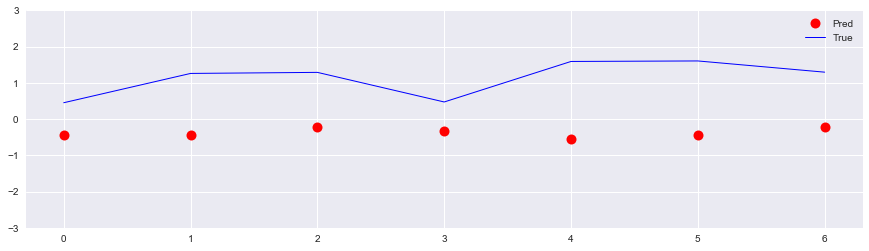

In [41]:
plt.figure(figsize=(15,4))
plt.plot(y_pred, 'ro', ms=10)
plt.plot(y_test, 'b-', lw=1)
plt.legend(['Pred','True'], loc='best')
plt.ylim((-3,3))
plt.show()

## 4. Tuning `history` parameter

In [93]:
def tune_history_parameter(X, y, histories, model, parameters, test_size=0.2):
    train_errors = []
    test_errors = []
    min_error = 1e+9
    
    for i in enumerate(histories):
        X_train, X_test, y_train, y_test, ss, Y_MEAN, Y_STD = preprocess_data(X, y, histories[i[0]], test_size=test_size)
        gs_clf = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=4, n_jobs=-1, verbose=False)
        gs_clf.fit(X_train, y_train)
        clf = gs_clf.best_estimator_
        train_errors.append(-1*gs_clf.best_score_)
        y_pred = clf.predict(X_test)
        error = mean_squared_error(y_test, y_pred)
        test_errors.append(error)
        
        if i[0]==0:
            print('Number of steps: ', len(histories))
            best_clf = clf
            best_params = gs_clf.best_params_
        if (error <= min_error):
            min_error = error
            idx_min = i[0]
            best_clf = clf
            best_params = gs_clf.best_params_
            
        print(str(i[0]+1)+'-th step is done!')
        print('Error: \t', error)
        
    return min_error, histories[idx_min], best_clf, best_params

In [94]:
svr_model = SVR()

parameters_svr = {
    'C': np.logspace(-4,4,9),
    'kernel': ['rbf', 'sigmoid', 'linear'],
    'degree': np.arange(1, 10),
    'epsilon': [1e-1, 8e-2, 5e-1, 1e-2,1e-1,3e-1,1e-3]
}

histories = np.arange(1,6)

min_error, best_history, best_clf, best_params = tune_history_parameter(X_matdoc,y, histories, svr_model, parameters_svr, test_size=test_size)

Number of steps:  5
1-th step is done!
Error: 	 3.08602805138
2-th step is done!
Error: 	 2.64619583144
3-th step is done!
Error: 	 3.26189979253
4-th step is done!
Error: 	 3.02786946414
5-th step is done!
Error: 	 2.21894090503


In [95]:
X_train, X_test, y_train, y_test, ss, Y_MEAN, Y_STD = preprocess_data(X_matdoc, y, best_history, test_size=test_size)

In [96]:
best_params

{'C': 10.0, 'degree': 1, 'epsilon': 0.001, 'kernel': 'rbf'}

In [97]:
clf = SVR(C=best_params['C'], degree=best_params['degree'], epsilon=best_params['epsilon'], kernel=best_params['kernel'])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)
train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_pred)
print('Training error:\t', train_error)
print('Test error:\t', test_error)

Training error:	 1.08096200212e-06
Test error:	 2.21894090503


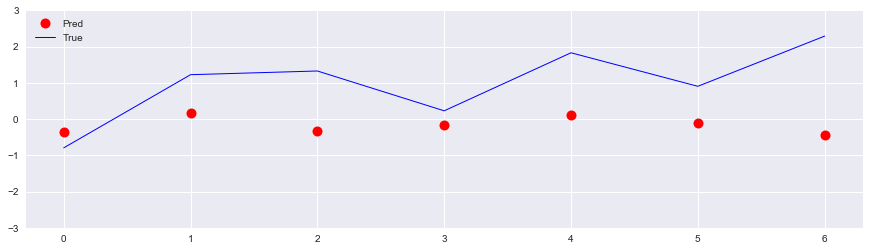

In [98]:
plt.figure(figsize=(15,4))
plt.plot(y_pred, 'ro', ms=10)
plt.plot(y_test, 'b-', lw=1)
plt.legend(['Pred','True'], loc='best')

plt.ylim((-3,3))
plt.show()

## 5. Step-by-step month prediction

In [99]:
def predict_step_by_step(clf, X_train, X_test, y_train, y_test):
    y_pred = []
    X_test_copy = X_test.copy()
    
    N_MONTHS = X_test.shape[0]
    for i in range(N_MONTHS-1):
        x = X_test[i, :].copy()
        #predict on the next month
        y = clf.predict([x])
        y_pred.append(y)
        #change train and test data
        X_train = np.vstack((X_train, x))
        y_train = np.concatenate((y_train,np.array(y)))

        #retrain our model
        clf.fit(X_train, y_train)
    #predict on the last month    
    y = clf.predict([X_test[-1,:]])
    y_pred.append(y)
        
    y_pred = np.array(y_pred)
    return y_pred

In [100]:
y_pred_sbs = predict_step_by_step(clf, X_train, X_test, y_train, y_test)
train_error = mean_squared_error(y_train, y_train_pred)
test_sbs_error = mean_squared_error(y_test, y_pred_sbs)
test_error = mean_squared_error(y_test, y_pred)
print('Training error:\t\t\t', train_error)
print('Test error:\t\t\t', test_error)
print('Test step-by-step error:\t', test_sbs_error)

Training error:			 1.08096200212e-06
Test error:			 2.21894090503
Test step-by-step error:	 2.21894090503


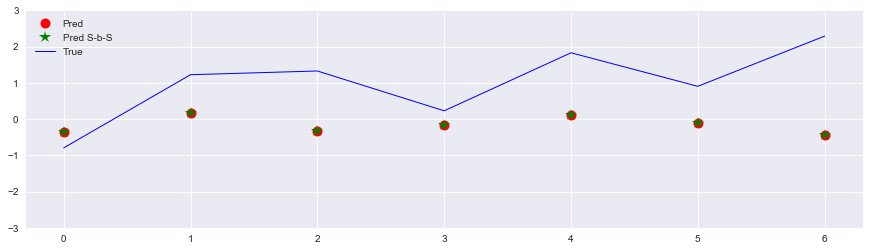

In [101]:
plt.figure(figsize=(15,4))
plt.plot(y_pred, 'ro', ms=10)
plt.plot(y_pred_sbs, 'g*', ms=12)
plt.plot(y_test, 'b-', lw=1)
plt.legend(['Pred','Pred S-b-S','True'], loc='best')

plt.ylim((-3,3))
plt.show()

#### Shift prediction on 2 months:

In [102]:
X_train_ = np.vstack((X_train[2:,:], X_test[:2,:]))
y_train_ = np.concatenate((y_train[2:], y_test[:2]))

In [103]:
clf.fit(X_train_,y_train_)

SVR(C=10.0, cache_size=200, coef0=0.0, degree=1, epsilon=0.001, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [104]:
y_pred_ = clf.predict(X_test[2:,:])

In [105]:
y_test_ = y_test[2:]

In [106]:
mean_squared_error(y_test_,y_pred_)

2.5514880250942924

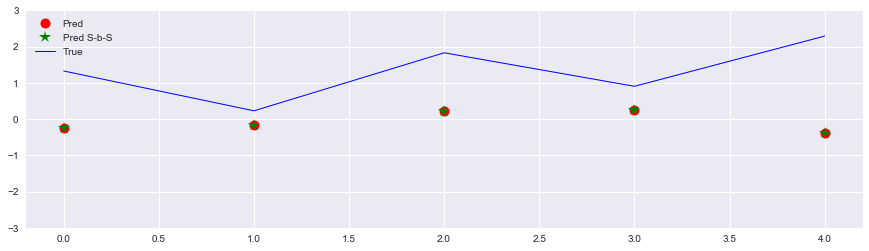

In [107]:

plt.figure(figsize=(15,4))
plt.plot(y_pred_, 'ro', ms=10)
plt.plot(predict_step_by_step(clf,X_train_,X_test[2:,:], y_train_,y_test[2:]), 'g*', ms=12)
plt.plot(y_test_, 'b-', lw=1)
plt.legend(['Pred','Pred S-b-S','True'], loc='best')

plt.ylim((-3,3))
plt.show()